<a href="https://colab.research.google.com/github/sharon-kurant/VCE_Remission_Classification/blob/main/leak_fix_VCE_classification_with_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
import json
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from transformers import AutoImageProcessor, TimesformerForVideoClassification
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
args = { "num_frames" : 64,
         "batch_size" : 2,
         "multiplier" : 1,
         "train_csv" : '/content/drive/MyDrive/remission/tagged_csv/train_61_videos.csv',
        #  "video_dir" : '/content/drive/MyDrive/remission/data_5fps',
        #  "stills_model": keras.models.load_model("/content/drive/MyDrive/remission/models/resnet_stills_finetuned_224.keras")
}

In [5]:
num_frames = args["num_frames"]
batch_size = args["batch_size"]
multiplier = args["multiplier"]
train_csv = args["train_csv"]
# representative_frames = np.load('/content/drive/MyDrive/remission/results/'+f'representative_frames_{num_frames}.npy',allow_pickle='TRUE').item()
# stills_model = args["stills_model"]

In [6]:
class VideoDataset(Dataset):
  def __init__(self, tagged_csv=None, stills_model=None, num_frames=16, transform=None, preload_representative=None):
    self.tagged_csv = tagged_csv
    self.video_df = pd.read_csv(self.tagged_csv)
    self.stills_model = stills_model
    self.num_frames = num_frames
    self.transform = transform

    self.video_paths = self.video_df['video_path'].tolist()
    self.labels = self.video_df['label'].tolist()            # binary0/1

    self.num_videos = len(self.video_df)

    if preload_representative:
      self.representative_frames = representative_frames
    else:
      self.representative_frames = {}

  def __len__(self):
    return len(self.video_paths)

  def __getitem__(self, idx):
    # Normalize
    idx %= 61
    video_path = self.video_paths[idx]

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Set equally divided intervals
    intervals = np.linspace(0, total_frames, self.num_frames + 1, dtype=int)

    # Check if representative frames already exists
    if bool(self.representative_frames):
      frame_indices = [frame_i for frame_i, prob in self.representative_frames[video_path]]
      print(frame_indices)
    # Check if stills model exists and if so -> get a representative frame from each interval
    # elif self.stills_model:
    #   frame_indices = [self.choose_representative(idx, low=intervals[i], high=intervals[i + 1]) for i in range(self.num_frames)]
    # Get random frame from each interval
    else:
      frame_indices = [torch.randint(low=intervals[i], high=intervals[i + 1], size=(1,)) for i in range(self.num_frames)]

    # frame_indices = torch.concatenate(frame_indices)

    # Initialize empty frame list
    frames = []

    # Read frames
    for i in frame_indices:
        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(i))

        # Read the frame
        ret, frame = cap.read()

        if not ret:
            # Handle the case where reading the frame fails
            raise RuntimeError(f"Failed to read frame {i} from video {video_path}")

        # Convert the frame from BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if self.transform:
          frame = self.transform(frame)
        # Append the frame to the list of frames
        frames.append(frame)

    # Close the video file
    cap.release()

    # Convert frames to a tensor
    frames = torch.stack(frames)

    return frames, self.labels[idx]

In [7]:
# Define transformations
def get_transform():
  transform = transforms.Compose([
      # Add any transformations you need (e.g., normalization, resizing)
      transforms.ToPILImage(),
      transforms.CenterCrop((510,510)),
      transforms.ColorJitter(),
      transforms.RandomCrop(224),
      # transforms.Resize((224,224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.47, 0.3, 0.15], std=[0.023, 0.018, 0.026])
  ])
  return transform

# Define your dataset and DataLoader
# num_classes = 2  # Adjust based on your classification task

# dataset = VideoDataset(tagged_csv=train_csv, stills_model=None, num_frames=num_frames, transform=get_transform(), preload_representative=False)

In [8]:
def get_model(model_ckpt = "fcakyon/timesformer-large-finetuned-ssv2"):
  # model_ckpt =  'facebook/timesformer-hr-finetuned-ssv2' # "fcakyon/timesformer-large-finetuned-ssv2" #
  # image_processor = AutoImageProcessor.from_pretrained(model_ckpt)
  model = TimesformerForVideoClassification.from_pretrained(
      model_ckpt,
      # label2id=dataset.label2id,
      # id2label=dataset.id2label,
      output_hidden_states=True,
      ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
  )

  model.classifier = nn.Sequential(
      nn.Linear(in_features=768, out_features=1, bias=True),
      nn.Sigmoid(),
  )
  return model

In [22]:
# Define your dataset
dataset = VideoDataset(tagged_csv=train_csv, stills_model=None, num_frames=num_frames, transform=get_transform(), preload_representative=False)

lrs = [5e-6]
multipliers = [15]
num_epochs = 3
lr_mult_pairs = list(itertools.product(lrs, multipliers))
num_folds = 5

for lr, multiplier in lr_mult_pairs:
    label_pred_pairs = []

# Assuming 'experiments' is defined
# for experiment in range(experiments):
    # Assuming 'num_folds', 'multiplier', 'lr', 'batch_size', 'num_epochs' are defined

    # Initialize metrics storage for all folds
    all_folds_train_losses, all_folds_val_losses = [], []
    all_folds_train_aucs, all_folds_val_aucs = [], []
    all_folds_train_accuracies, all_folds_val_accuracies = [], []

    # print(f"Experiment {experiment+1}/{experiments}")

    # StratifiedKFold setup
    kfs = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)

    for fold, (train_indices, val_indices) in enumerate(kfs.split(dataset.video_paths, dataset.labels)):
        print(f"Starting Fold {fold+1}/{num_folds}")

        # Reinitialize the model and setup loss and optimizer for each fold
        model = get_model().to(device)
        class_weights = torch.tensor(61 / (2 * np.array([44,17])), dtype=torch.float).to(device)
        criterion = nn.BCELoss(weight=class_weights)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Prepare DataLoader for training and validation sets
        train_examples = train_indices.repeat(multiplier)
        val_examples = val_indices.repeat(multiplier)
        train_set = torch.utils.data.Subset(dataset, train_examples)
        val_set = torch.utils.data.Subset(dataset, val_examples)
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)

        fold_train_losses, fold_val_losses = [], []
        fold_train_aucs, fold_val_aucs = [], []
        fold_train_accuracies, fold_val_accuracies = [], []

        for epoch in range(num_epochs):
            # Training step
            model.train()
            train_loss, train_probs, train_targets = 0, [], []
            for batch in tqdm(train_loader, desc=f'Fold {fold + 1}/{num_folds} | Epoch {epoch + 1}/{num_epochs} - Training'):

                frames, labels = batch
                # Move data to CUDA
                frames, labels = frames.to(device), labels.float().to(device)

                optimizer.zero_grad()
              # Forward pass
                outputs = model(frames)

                # Compute the loss
                loss = criterion(outputs.logits.view(labels.size()), labels)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Get predicted probabilities for metrics
                probs_train = outputs.logits.squeeze().detach().cpu().numpy()
                train_targets.extend(labels.cpu().numpy())
                train_probs.extend(list(probs_train))


            # Calculate training metrics
            train_auc = roc_auc_score(train_targets, train_probs)
            train_accuracy = accuracy_score(train_targets, np.array(train_probs) > 0.5)
            fold_train_losses.append(train_loss / len(train_loader))
            fold_train_aucs.append(train_auc)
            fold_train_accuracies.append(train_accuracy)

            # Validation step
            model.eval()
            val_loss, val_probs, val_targets = 0, [], []
            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f'Fold {fold + 1}/{num_folds} | Epoch {epoch + 1}/{num_epochs} - Validation'):
                    frames, labels = batch
                    # Move data to CUDA
                    frames, labels = frames.to(device), labels.float().to(device)
                    outputs = model(frames)
                    loss = criterion(outputs.logits.squeeze(), labels)

                    outputs = model(frames)
                    val_loss += loss.item()

                    val_probs.extend(outputs.logits.squeeze().cpu().numpy())
                    val_targets.extend(labels.cpu().numpy())


                    # # Get predicted probabilities for metrics
                    # probs_val = outputs.logits.squeeze().cpu().numpy()
                    # all_labels_val.extend(labels.cpu().numpy())
                    # all_probs_val.extend(list(probs_val))
                    # label_pred_pairs.append(list(zip(labels.cpu().numpy(), probs_val)))

            # Calculate validation metrics
            val_auc = roc_auc_score(val_targets, val_probs)
            val_accuracy = accuracy_score(val_targets, np.array(val_probs) > 0.5)
            fold_val_losses.append(val_loss / len(val_loader))
            fold_val_aucs.append(val_auc)
            fold_val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch+1}: Train Loss: {fold_train_losses[-1]:.4f}, Train AUC: {fold_train_aucs[-1]:.4f}, Train Acc: {fold_train_accuracies[-1]:.4f}\n\tVal Loss: {fold_val_losses[-1]:.4f}, Val AUC: {fold_val_aucs[-1]:.4f}, Val Acc: {fold_val_accuracies[-1]:.4f}")

        # Aggregate results for the fold
        all_folds_train_losses.append(np.mean(fold_train_losses))
        all_folds_train_aucs.append(np.mean(fold_train_aucs))
        all_folds_train_accuracies.append(np.mean(fold_train_accuracies))
        all_folds_val_losses.append(np.mean(fold_val_losses))
        all_folds_val_aucs.append(np.mean(fold_val_aucs))
        all_folds_val_accuracies.append(np.mean(fold_val_accuracies))

        torch.save(model.state_dict(), f'/content/drive/MyDrive/remission/models/remission_model_m{multiplier}_lr{lr}_f{num_frames}_e{num_epochs}_fold_{fold+1}_ver4')

    # Print aggregated results after all folds are processed
    print("Aggregated Results Across All Folds:")
    print(f"Average Training Loss: {np.mean(all_folds_train_losses):.4f}, Average Training AUC: {np.mean(all_folds_train_aucs):.4f}, Average Training Accuracy: {np.mean(all_folds_train_accuracies):.4f}")
    print(f"Average Validation Loss: {np.mean(all_folds_val_losses):.4f}, Average Validation AUC: {np.mean(all_folds_val_aucs):.4f}, Average Validation Accuracy: {np.mean(all_folds_val_accuracies):.4f}")


Starting Fold 1/5


Fold 1/5 | Epoch 1/3 - Training: 100%|██████████| 360/360 [39:19<00:00,  6.56s/it]
Fold 1/5 | Epoch 1/3 - Validation: 100%|██████████| 97/97 [09:36<00:00,  5.94s/it]


Epoch 1: Train Loss: 0.7396, Train AUC: 0.6076, Train Acc: 0.7139
	Val Loss: 0.8653, Val AUC: 0.4576, Val Acc: 0.6959


Fold 1/5 | Epoch 2/3 - Training: 100%|██████████| 360/360 [39:31<00:00,  6.59s/it]
Fold 1/5 | Epoch 2/3 - Validation: 100%|██████████| 97/97 [09:42<00:00,  6.00s/it]


Epoch 2: Train Loss: 0.6252, Train AUC: 0.7234, Train Acc: 0.7611
	Val Loss: 0.9368, Val AUC: 0.3091, Val Acc: 0.5412


Fold 1/5 | Epoch 3/3 - Training: 100%|██████████| 360/360 [39:23<00:00,  6.56s/it]
Fold 1/5 | Epoch 3/3 - Validation: 100%|██████████| 97/97 [09:38<00:00,  5.97s/it]


Epoch 3: Train Loss: 0.5217, Train AUC: 0.8436, Train Acc: 0.8153
	Val Loss: 1.0843, Val AUC: 0.4760, Val Acc: 0.6959
Starting Fold 2/5


Fold 2/5 | Epoch 1/3 - Training: 100%|██████████| 367/367 [39:56<00:00,  6.53s/it]
Fold 2/5 | Epoch 1/3 - Validation: 100%|██████████| 90/90 [09:06<00:00,  6.07s/it]


Epoch 1: Train Loss: 0.6294, Train AUC: 0.7451, Train Acc: 0.7752
	Val Loss: 1.4162, Val AUC: 0.0837, Val Acc: 0.5778


Fold 2/5 | Epoch 2/3 - Training: 100%|██████████| 367/367 [39:58<00:00,  6.54s/it]
Fold 2/5 | Epoch 2/3 - Validation: 100%|██████████| 90/90 [09:02<00:00,  6.03s/it]


Epoch 2: Train Loss: 0.4753, Train AUC: 0.8748, Train Acc: 0.8025
	Val Loss: 0.9974, Val AUC: 0.5635, Val Acc: 0.6000


Fold 2/5 | Epoch 3/3 - Training: 100%|██████████| 367/367 [39:52<00:00,  6.52s/it]
Fold 2/5 | Epoch 3/3 - Validation: 100%|██████████| 90/90 [09:04<00:00,  6.05s/it]


Epoch 3: Train Loss: 0.3737, Train AUC: 0.9283, Train Acc: 0.8747
	Val Loss: 1.5730, Val AUC: 0.3568, Val Acc: 0.5500
Starting Fold 3/5


Fold 3/5 | Epoch 1/3 - Training: 100%|██████████| 367/367 [40:02<00:00,  6.55s/it]
Fold 3/5 | Epoch 1/3 - Validation: 100%|██████████| 90/90 [09:04<00:00,  6.05s/it]


Epoch 1: Train Loss: 0.7343, Train AUC: 0.6343, Train Acc: 0.7207
	Val Loss: 0.7854, Val AUC: 0.4291, Val Acc: 0.6611


Fold 3/5 | Epoch 2/3 - Training: 100%|██████████| 367/367 [39:56<00:00,  6.53s/it]
Fold 3/5 | Epoch 2/3 - Validation: 100%|██████████| 90/90 [09:09<00:00,  6.11s/it]


Epoch 2: Train Loss: 0.6194, Train AUC: 0.7773, Train Acc: 0.7698
	Val Loss: 0.9515, Val AUC: 0.4341, Val Acc: 0.4889


Fold 3/5 | Epoch 3/3 - Training: 100%|██████████| 367/367 [40:03<00:00,  6.55s/it]
Fold 3/5 | Epoch 3/3 - Validation: 100%|██████████| 90/90 [09:07<00:00,  6.08s/it]


Epoch 3: Train Loss: 0.4592, Train AUC: 0.9058, Train Acc: 0.8283
	Val Loss: 1.0018, Val AUC: 0.3878, Val Acc: 0.5278
Starting Fold 4/5


Fold 4/5 | Epoch 1/3 - Training: 100%|██████████| 367/367 [40:11<00:00,  6.57s/it]
Fold 4/5 | Epoch 1/3 - Validation: 100%|██████████| 90/90 [09:02<00:00,  6.02s/it]


Epoch 1: Train Loss: 0.7118, Train AUC: 0.6489, Train Acc: 0.6935
	Val Loss: 0.7834, Val AUC: 0.3560, Val Acc: 0.7611


Fold 4/5 | Epoch 2/3 - Training: 100%|██████████| 367/367 [40:08<00:00,  6.56s/it]
Fold 4/5 | Epoch 2/3 - Validation: 100%|██████████| 90/90 [09:01<00:00,  6.02s/it]


Epoch 2: Train Loss: 0.5777, Train AUC: 0.8209, Train Acc: 0.7752
	Val Loss: 1.0310, Val AUC: 0.3895, Val Acc: 0.6111


Fold 4/5 | Epoch 3/3 - Training: 100%|██████████| 367/367 [40:11<00:00,  6.57s/it]
Fold 4/5 | Epoch 3/3 - Validation: 100%|██████████| 90/90 [09:13<00:00,  6.15s/it]


Epoch 3: Train Loss: 0.4326, Train AUC: 0.8959, Train Acc: 0.8297
	Val Loss: 1.1286, Val AUC: 0.4074, Val Acc: 0.7000
Starting Fold 5/5


Fold 5/5 | Epoch 1/3 - Training: 100%|██████████| 367/367 [40:05<00:00,  6.55s/it]
Fold 5/5 | Epoch 1/3 - Validation: 100%|██████████| 90/90 [09:12<00:00,  6.14s/it]


Epoch 1: Train Loss: 0.7187, Train AUC: 0.6242, Train Acc: 0.7166
	Val Loss: 0.7568, Val AUC: 0.4038, Val Acc: 0.8333


Fold 5/5 | Epoch 2/3 - Training: 100%|██████████| 367/367 [40:02<00:00,  6.55s/it]
Fold 5/5 | Epoch 2/3 - Validation: 100%|██████████| 90/90 [09:10<00:00,  6.12s/it]


Epoch 2: Train Loss: 0.6684, Train AUC: 0.7309, Train Acc: 0.7330
	Val Loss: 0.7735, Val AUC: 0.3480, Val Acc: 0.7500


Fold 5/5 | Epoch 3/3 - Training: 100%|██████████| 367/367 [39:47<00:00,  6.51s/it]
Fold 5/5 | Epoch 3/3 - Validation: 100%|██████████| 90/90 [09:11<00:00,  6.12s/it]


Epoch 3: Train Loss: 0.5902, Train AUC: 0.8101, Train Acc: 0.7629
	Val Loss: 0.8160, Val AUC: 0.4639, Val Acc: 0.7889
Aggregated Results Across All Folds:
Average Training Loss: 0.5918, Average Training AUC: 0.7714, Average Training Accuracy: 0.7715
Average Validation Loss: 0.9934, Average Validation AUC: 0.3911, Average Validation Accuracy: 0.6522


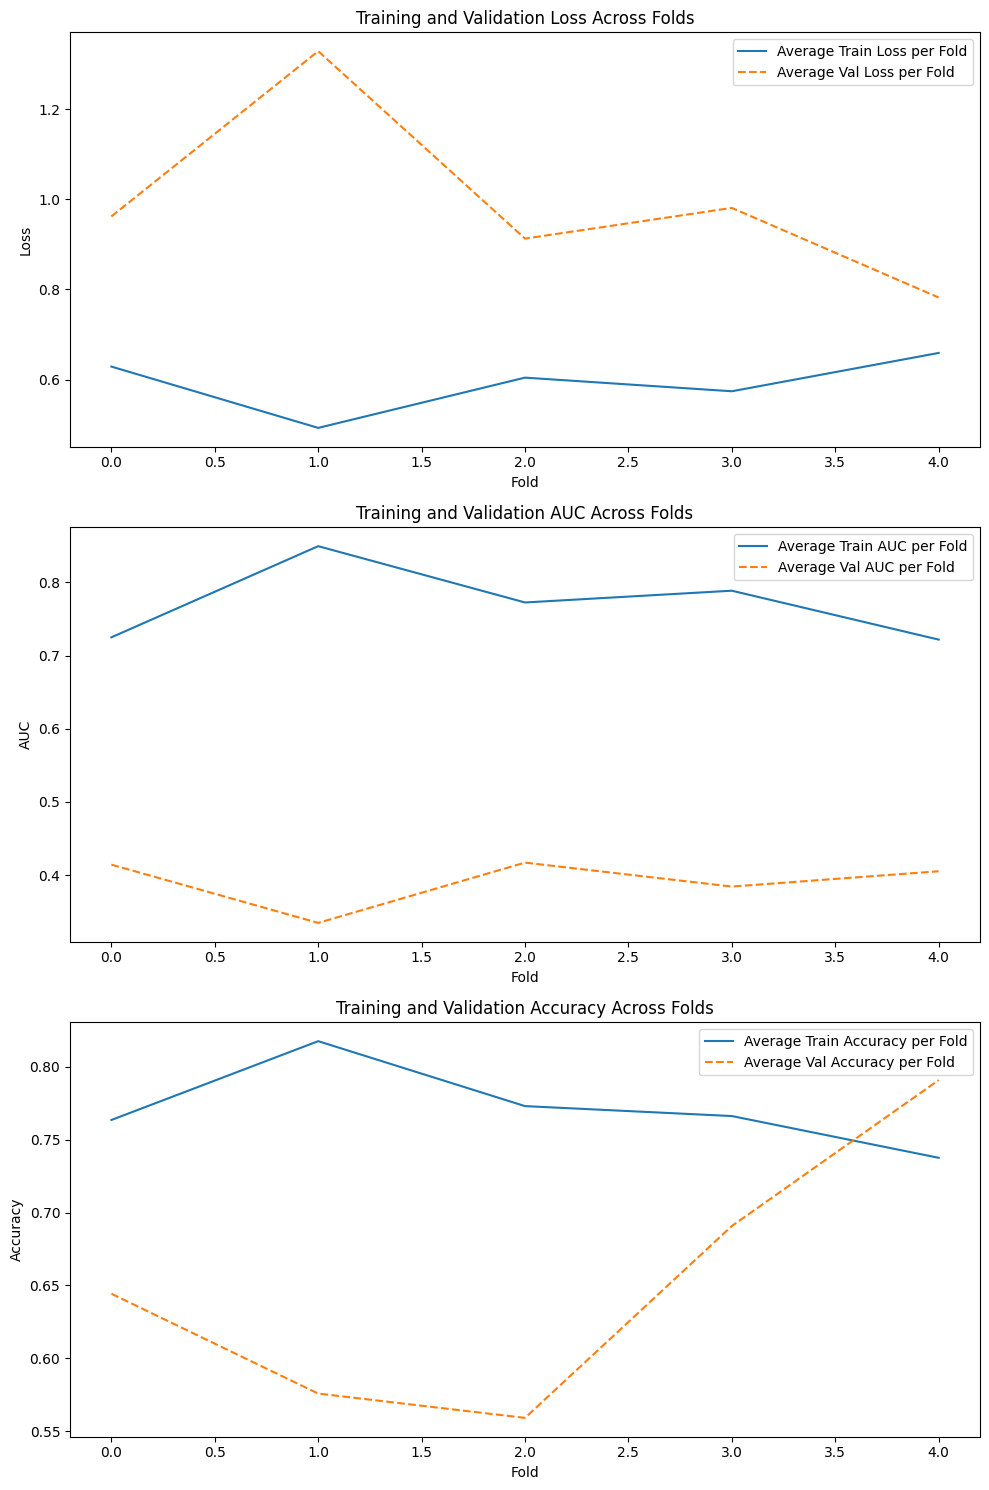

In [24]:
import matplotlib.pyplot as plt

# After all folds are processed and you have aggregated results
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot training loss
axs[0].plot(all_folds_train_losses, label='Average Train Loss per Fold')
axs[0].plot(all_folds_val_losses, label='Average Val Loss per Fold', linestyle='--')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Fold')
axs[0].set_title('Training and Validation Loss Across Folds')
axs[0].legend()

# Plot AUC
axs[1].plot(all_folds_train_aucs, label='Average Train AUC per Fold')
axs[1].plot(all_folds_val_aucs, label='Average Val AUC per Fold', linestyle='--')
axs[1].set_ylabel('AUC')
axs[1].set_xlabel('Fold')
axs[1].set_title('Training and Validation AUC Across Folds')
axs[1].legend()

# Plot accuracy
axs[2].plot(all_folds_train_accuracies, label='Average Train Accuracy per Fold')
axs[2].plot(all_folds_val_accuracies, label='Average Val Accuracy per Fold', linestyle='--')
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Fold')
axs[2].set_title('Training and Validation Accuracy Across Folds')
axs[2].legend()

plt.tight_layout()
# plt.savefig(f"./results/experiment_{experiment+1}_results.png")
plt.show()


In [28]:
# prompt: output model peformance ang to csv

# Create a dictionary with the performance metrics
performance_metrics = {
    'Train Loss': all_folds_train_losses,
    'Train AUC': all_folds_train_aucs,
    'Train Accuracy': all_folds_train_accuracies,
    'Validation Loss': all_folds_val_losses,
    'Validation AUC': all_folds_val_aucs,
    'Validation Accuracy': all_folds_val_accuracies
}

# Create a DataFrame from the dictionary
performance_df = pd.DataFrame(performance_metrics)

# Save the DataFrame to a CSV file
performance_df.to_csv(f'/content/drive/MyDrive/remission/results/performance_results_m{multiplier}_lr{lr}_f{num_frames}_e{num_epochs}_ver4.csv', index=False)
